# Task 1 : Set up colab gpu runtime environment

In [1]:
#!pip install segmentation-models-pytorch
#!pip install -U git+https://github.com/albumentations-team/albumentations
#!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


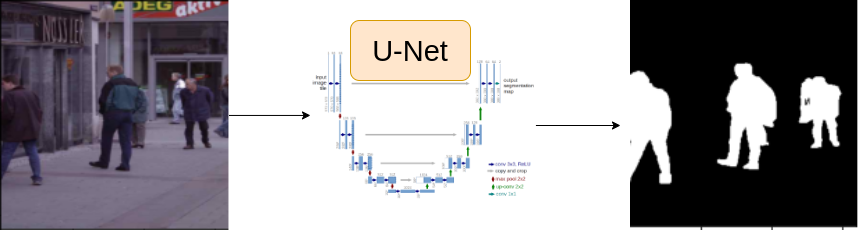

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
# get the first image at position 0 for visualization
row = df.iloc[0]

# use the .images attritute to get values and masks
image_path = row.images
mask_path = row.masks

# open cv2 to read the images
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

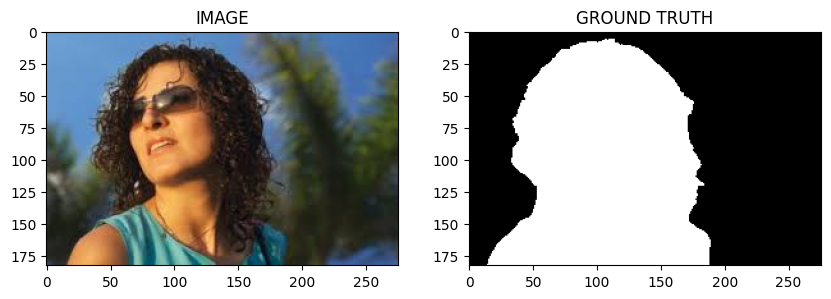

In [8]:
# Visualise the image and it ground truth
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(masks,cmap = 'gray');


In [9]:
# split the dataset into training and validation
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
# import library for augmentation
import albumentations as A

In [11]:
# function for training dataset augmentation
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
  ])


# function for validation dataset augmentation
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  # the initial method for the dataframe and augmentation
  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  # length of the dataframe
  def __len__(self):
    return len(self.df)

  # get item the image attributes
  def __getitem__(self, index):
    row = self.df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if image.shape != mask.shape:
            # Resize or crop either image or mask to match dimensions
            # Example:
            image = cv2.resize(image, (mask.shape[1], mask.shape[0]))

    data = self.augmentations(image=image, mask=mask)
    image = data['image']
    mask = data['mask']

    # (h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)


    # convert from numpy to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) /255.0)

    return image, mask

In [14]:
# now call the SegmentationDataset class to augment the train_df and valid_df
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


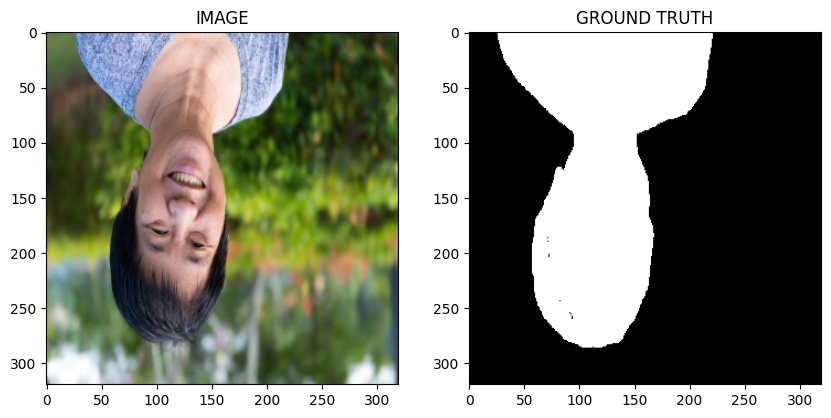

In [16]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
# load dataset with dataloader
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [19]:
print(f"Size of Trainloader : {len(trainloader)}")
print(f"Size of Validloader : {len(validloader)}")

Size of Trainloader : 15
Size of Validloader : 4


In [20]:
for image, mask in trainloader:
  break
print(f"Image shape : {image.shape}")
print(f"Mask shape : {mask.shape}")

Image shape : torch.Size([16, 3, 320, 320])
Mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, mask = None):

    logits = self.arc(images)

    if mask is not None:
      loss1 = DiceLoss(mode="binary")(logits, mask)
      loss2 = nn.BCEWithLogitsLoss()(logits, mask)
      return logits, loss1 + loss2

    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [24]:
def train_fn(model, dataloader, optimizer):
  model.train()
  train_loss = 0
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    optimizer.step()
    train_loss += loss.item()

    total_loss = train_loss / len(dataloader)
  return total_loss

In [25]:
def eval_fn(model, dataloader):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()
  return total_loss / len(dataloader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [27]:
best_valid_loss = np.inf

for epoch in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pth')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"EPOCH : {epoch+1} | Train Loss : {train_loss} | Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


SAVED-MODEL
EPOCH : 1 | Train Loss : 1.4287311474482218 | Valid Loss : 1.4031025171279907


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


EPOCH : 2 | Train Loss : 1.4308938185373943 | Valid Loss : 1.4230323433876038


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


EPOCH : 3 | Train Loss : 1.434638222058614 | Valid Loss : 1.4352859556674957


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


EPOCH : 4 | Train Loss : 1.4325640281041463 | Valid Loss : 1.4421772956848145


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


EPOCH : 5 | Train Loss : 1.432844630877177 | Valid Loss : 1.4433667957782745


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


EPOCH : 6 | Train Loss : 1.4338859875996908 | Valid Loss : 1.441248208284378


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


EPOCH : 7 | Train Loss : 1.437354596455892 | Valid Loss : 1.441978245973587


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


EPOCH : 8 | Train Loss : 1.4326312303543092 | Valid Loss : 1.4440999329090118


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


EPOCH : 9 | Train Loss : 1.4330389022827148 | Valid Loss : 1.4436544179916382


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


EPOCH : 10 | Train Loss : 1.4290063540140787 | Valid Loss : 1.443980097770691


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


EPOCH : 11 | Train Loss : 1.4341334104537964 | Valid Loss : 1.443794697523117


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


EPOCH : 12 | Train Loss : 1.4315561850865681 | Valid Loss : 1.4437027275562286


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


EPOCH : 13 | Train Loss : 1.4317664782206216 | Valid Loss : 1.4434953331947327


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


EPOCH : 14 | Train Loss : 1.4339383363723754 | Valid Loss : 1.4430471062660217


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


EPOCH : 15 | Train Loss : 1.4324187199274698 | Valid Loss : 1.443268597126007


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


EPOCH : 16 | Train Loss : 1.4287925243377686 | Valid Loss : 1.4442388415336609


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


EPOCH : 17 | Train Loss : 1.4317500829696654 | Valid Loss : 1.4432022869586945


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


EPOCH : 18 | Train Loss : 1.4332330226898193 | Valid Loss : 1.4438944160938263


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


EPOCH : 19 | Train Loss : 1.430583620071411 | Valid Loss : 1.443424254655838


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


EPOCH : 20 | Train Loss : 1.4363232930501302 | Valid Loss : 1.4428188502788544


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


EPOCH : 21 | Train Loss : 1.4363471825917562 | Valid Loss : 1.4412045776844025


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


EPOCH : 22 | Train Loss : 1.436867356300354 | Valid Loss : 1.4426824748516083


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


EPOCH : 23 | Train Loss : 1.4310657898585002 | Valid Loss : 1.4436261057853699


100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


EPOCH : 24 | Train Loss : 1.4328397830327353 | Valid Loss : 1.443238526582718


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

EPOCH : 25 | Train Loss : 1.434711996714274 | Valid Loss : 1.4417061805725098


# Task 9 : Inference

In [39]:
def inference(indx):
  idx = indx

  model.load_state_dict(torch.load('/content/best_model.pth'))

  image, mask = validset[idx]


  logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > 0.5)*1.0

  return helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

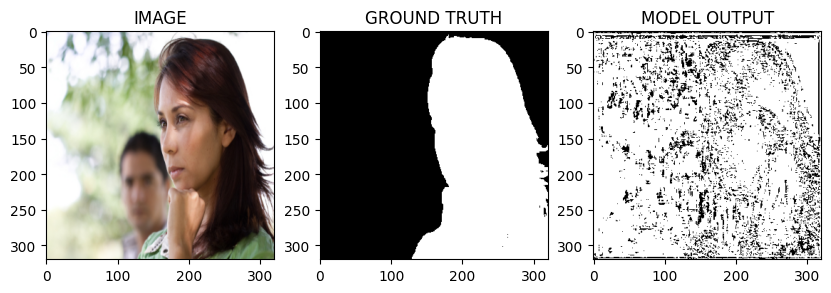

In [43]:
inference(3)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya